In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [4]:
main_dir = '/home/yulia/W266-Final-Project/'

In [5]:
data_path = main_dir+'data/raw/hein-daily'

In [6]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [7]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

### Create 30% sample because age model has more data where target = 1

In [17]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt', p=0.3)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 10.7 seconds to create the dictionary


In [18]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [19]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

### Data QA

In [20]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,789148
2,1,69491


Target group number of speeches by party:
A: 	 0
D: 	 50412
I: 	 0
N: 	 0
NA: 	 -3007562
P: 	 0
R: 	 19079

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,784049
2,1,74590


Target group number of speeches by party:
A: 	 4
D: 	 66088
I: 	 27
N: 	 89
NA: 	 -3007562
P: 	 20
R: 	 8362

 Age
Overall speech counts:


,Category,Count
0,-1,3007562
1,0,559313
2,1,299326


Target group number of speeches by party:
A: 	 4
D: 	 148670
I: 	 119
N: 	 89
NA: 	 -3007562
P: 	 20
R: 	 150424


In [21]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 19991109
char_count 213
word_count 40
speakerid 106121791.0
Party D
Congress 106
Chamber S
State OR
Ethnicity W
Age 51.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. WYDEN
Full Name WYDEN, RON
match exact
check 1

Mr. President. I noticed Senator GRASSLEY. who worked very hard on this bill. is trying to get a consent agreement. I will hold off if he is ready to go forward. Otherwise. I will proceed because I have the floor.


# Age Model

## Split into train, validate, test

In [22]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, age, descr)

Training split: 114524 ones and 114524 zeroes
Training speech list size: 229048
Training target list size: 229048
Validation split: 38174 ones and 38174 zeroes
Validation speech list size: 76348
Validation target list size: 76348
Test split: 38176 ones and 38176 zeroes
Test speech list size: 76352
Test target list size: 76352


In [23]:
sum(train_target), sum(val_target), sum(test_target)

(114524, 38174, 38176)

In [25]:
# number of speeches under 30 words
sum(np.array(age)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

108452

In [26]:
# random speech from a train set where target=1
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19980421
char_count 474
word_count 88
speakerid 105120730.0
Party D
Congress 105
Chamber H
State NJ
Ethnicity W
Age 47.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. PALLONE
Full Name PALLONE, FRANK
match exact
check 1

If I could point out another thing that is very unclear. it seems to me. and maybe the gentleman would respond to -that right -now. because he mentioned sale of a home. which is included in this proposal for the sales tax. We have people. homeowners that rely very heavily on mortgage interest deductions and also in my State. and I think many States. you can also deduct your local property taxes from your income tax. It is not at all clear to me that this would continue.


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [27]:
explore_data.get_num_words_per_sample(train)

230.0

In [28]:
explore_data.get_num_words_per_sample(val)

231.0

In [29]:
explore_data.get_num_words_per_sample(test)

228.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  45.0  73.0  121.0  175.0  230.0  303.0  397.0  545.0  840.0  17835.0


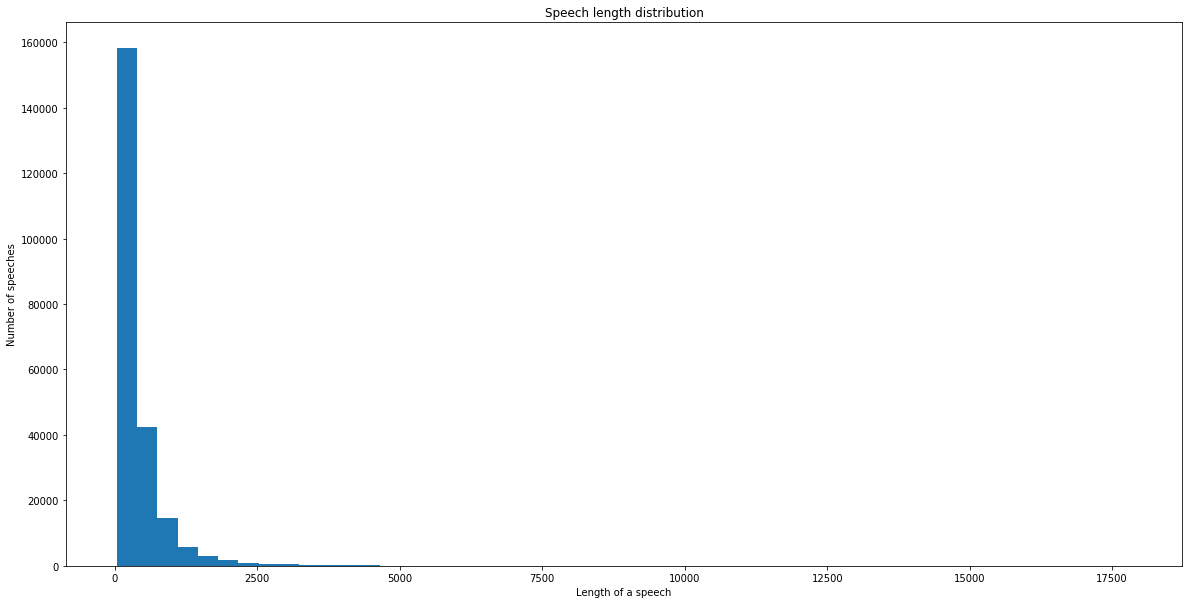

In [30]:
explore_data.plot_sample_length_distribution(train)

In [31]:
train_party = [descr[train_ids[i]]['Party'] for i in range(len(train_ids))]

In [32]:
explore_data.get_counts_by_category(train_target, train_party)

A: 	 1
D: 	 58139
I: 	 64
N: 	 35
P: 	 10
R: 	 56275


### Most popular ngrams (training only) - exluding stop words

In [33]:
# take a sample to avoid running out of memory
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

45809

['we', 'it', 'have', 'are', 'not', 'be', 'as', 'with', 'our', 'will', 'from', 'by', 'has', 'they', 'was', 'would', 'an', 'my', 'their', 'at', 'but', 'bill', 'or', 'who', 'all', 'he', 'do', 'president', 'which', 'his', 'there', 'what', 'been', 'people', 'about', 'if', 'you', 'these', 'so', 'more', 'one', 'time', 'can', 'speaker', 'amendment', 'years', 'those', 'no', 'states', 'when']


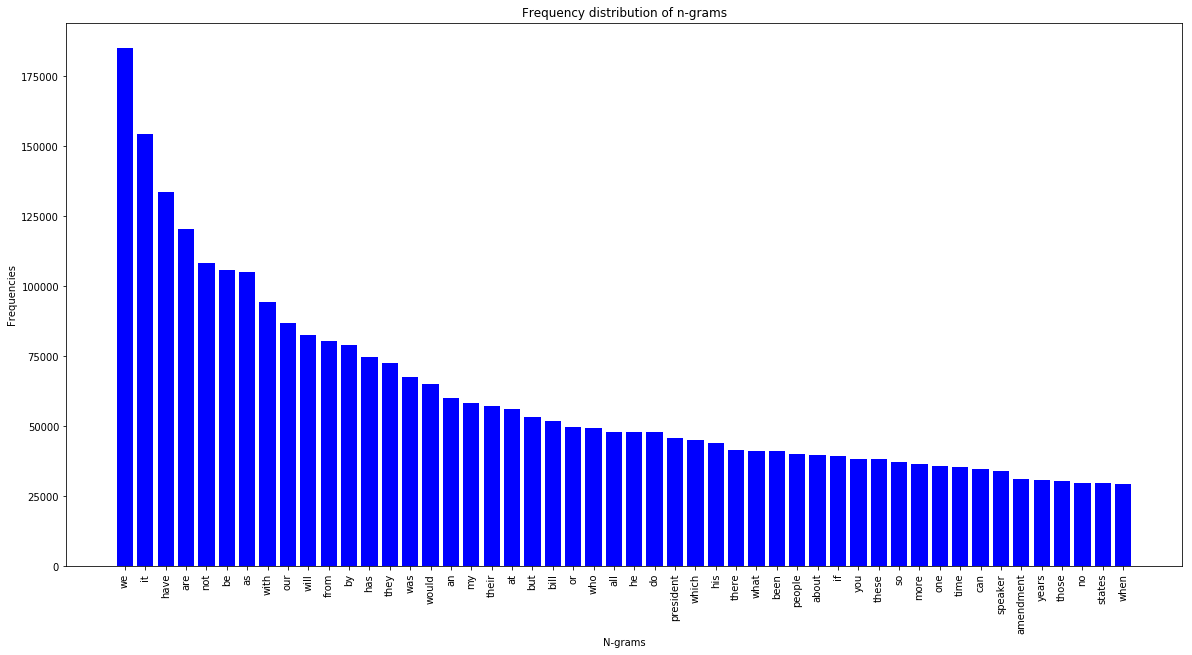

In [34]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

['in the', 'to the', 'it is', 'on the', 'and the', 'for the', 'that the', 'mr speaker', 'we have', 'to be', 'we are', 'that is', 'by the', 'that we', 'with the', 'mr president', 'of this', 'in this', 'going to', 'united states', 'the united', 'is the', 'will be', 'at the', 'the senate', 'from the', 'has been', 'is not', 'this is', 'this bill', 'want to', 'have been', 'of our', 'the gentleman', 'do not', 'my colleagues', 'there is', 'the house', 'to do', 'the bill', 'they are', 'would be', 'one of', 'the american', 'as the', 'the president', 'to make', 'have to', 'we can', 'the federal']


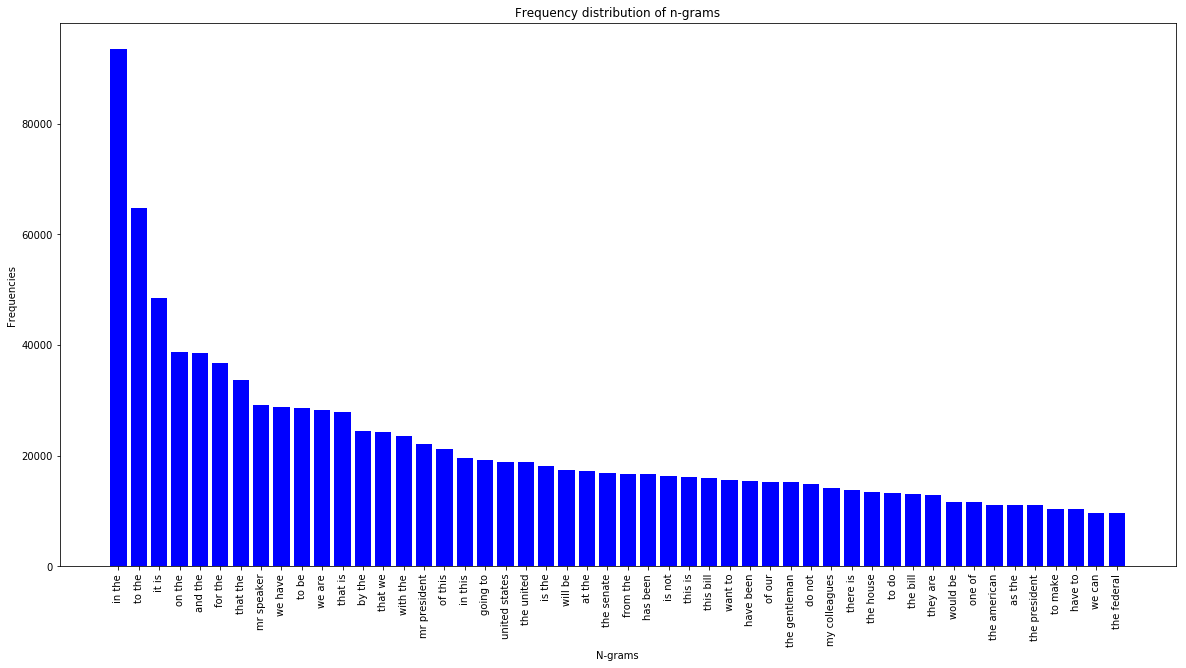

In [35]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

['the united states', 'the gentleman from', 'are going to', 'one of the', 'would like to', 'the senator from', 'the american people', 'my colleagues to', 'of the united', 'the department of', 'we are going', 'is going to', 'it is not', 'be able to', 'as well as', 'we need to', 'ask unanimous consent', 'the federal government', 'chairman of the', 'that we have', 'in this country', 'member of the', 'in the united', 'mr speaker rise', 'going to be', 'in order to', 'urge my colleagues', 'the committee on', 'that we are', 'there is no', 'of the senate', 'unanimous consent that', 'some of the', 'percent of the', 'we do not', 'rise today to', 'part of the', 'that is the', 'members of the', 'the fact that', 'in support of', 'and that is', 'of the house', 'thank the gentleman', 'we have to', 'the people of', 'speaker rise today', 'the state of', 'in the senate', 'of the aisle']


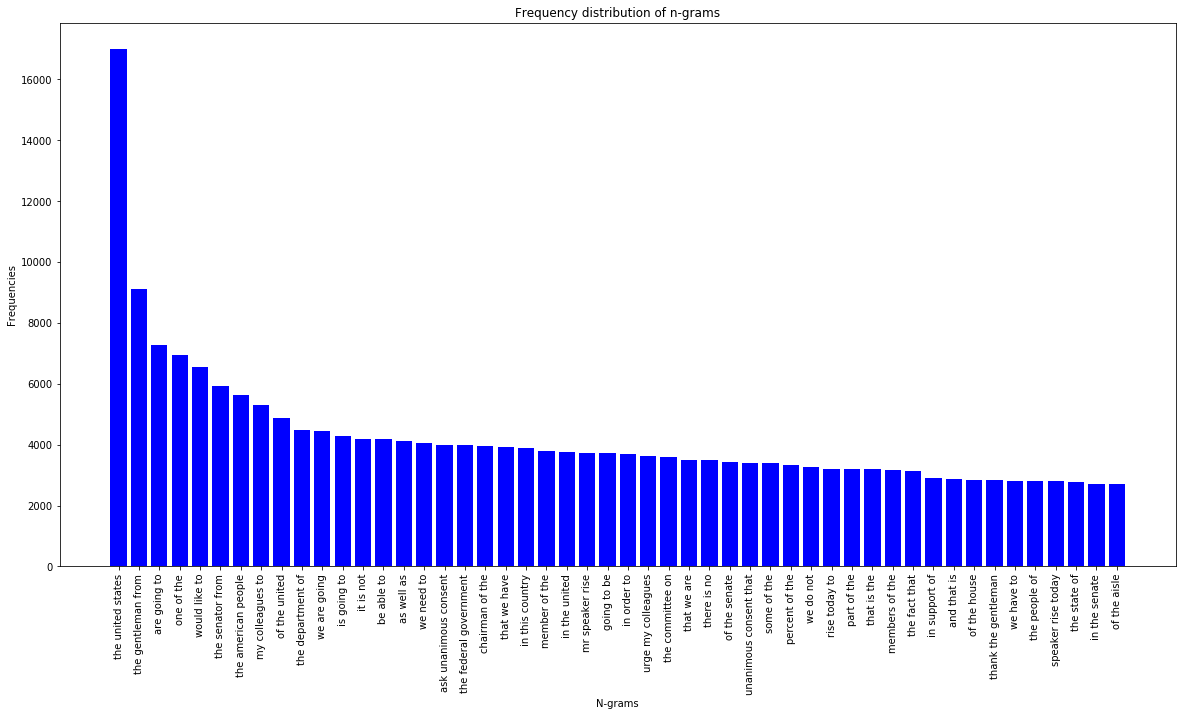

In [36]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [37]:
congress = set([str(i) for i in range(97,115)])

In [38]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 108 top 5 (3, 3) ngrams are:
the united states
the gentleman from
are going to
one of the
would like to
--------------------

For Congress 106 top 5 (3, 3) ngrams are:
the united states
the gentleman from
one of the
are going to
would like to
--------------------

For Congress 111 top 5 (3, 3) ngrams are:
the united states
the american people
are going to
one of the
my colleagues to
--------------------

For Congress 113 top 5 (3, 3) ngrams are:
the united states
are going to
mr speaker rise
the american people
one of the
--------------------

For Congress 114 top 5 (3, 3) ngrams are:
the united states
mr speaker rise
are going to
we need to
one of the
--------------------

For Congress 102 top 5 (3, 3) ngrams are:
the united states
the gentleman from
one of the
would like to
are going to
--------------------

For Congress 98 top 5 (3, 3) ngrams are:
the united states
the senator from
would like to
the gentleman from
one of the
--------------------

For Congress 110 top 5

In [39]:
explore_data.ngrams_by_category(train, train_ids, descr, {'D','R'}, 'Party', p=0.3, top_n=10)


For Party D top 10 (3, 3) ngrams are:
the united states
the gentleman from
one of the
are going to
would like to
the senator from
my colleagues to
the american people
of the united
the department of
--------------------

For Party R top 10 (3, 3) ngrams are:
the united states
the gentleman from
are going to
one of the
would like to
the american people
the senator from
of the united
we are going
my colleagues to
--------------------


In [40]:
del all_speeches, all_speech_ids, descr

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [41]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 10000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [43]:
reload(preprocess_data)
start_time = time.time()
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Total vocabulary size: 1107357
Number of stop words 7796658

Top 5 ngrams by differentiating score:
mr president 	 6851.7
president 	 4377.0
senator 	 3586.0
senate 	 3080.1
the senate 	 2935.9

Bottom 5 ngrams by differentiating score:
tolls 	 0.0
further indicated 	 0.0
personnel being 	 0.0
veterans eligibility 	 0.0
to piecemeal 	 0.0

It took 625.5 seconds to create the dictionary


In [44]:
len(train), len(val), len(test)

(229048, 76348, 76352)

In [45]:
train_vec.shape, val_vec.shape, test_vec.shape

((229048, 10000), (76348, 10000), (76352, 10000))

### Saving processed files

In [46]:
vecdata_path = main_dir+'Classification/data/vectorized/age'

In [47]:
scipy.sparse.save_npz(os.path.join(vecdata_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(vecdata_path, 'test_vec.npz'), test_vec)

In [48]:
train_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(vecdata_path, 'test_vec.npz'))

In [48]:
train_vec.shape, val_vec.shape, test_vec.shape

((229048, 10000), (76348, 10000), (76352, 10000))

In [49]:
outdata_path = main_dir+'Classification/data/splits/age'

In [50]:
with open(os.path.join(outdata_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(outdata_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(outdata_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(outdata_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(outdata_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(outdata_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(outdata_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(outdata_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(outdata_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [51]:
sum(train_target), sum(val_target), sum(test_target)

(114524, 38174, 38176)

In [53]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [54]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [52]:
sum(val_target), len(val_target)

(38174, 76348)

In [56]:
with open(os.path.join(outdata_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [57]:
sum(train_target), sum(val_target), sum(test_target)

(14140, 4713, 4714)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [53]:
logs_base_dir = main_dir + 'Classification/logs/Age'

In [54]:
ngram_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [55]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **ngram_model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 229048 samples, validate on 76348 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 48s - loss: 0.6330 - acc: 0.6367 - val_loss: 0.6245 - val_acc: 0.6431
Epoch 2/1000
 - 48s - loss: 0.6069 - acc: 0.6611 - val_loss: 0.6230 - val_acc: 0.6450
Epoch 3/1000
 - 48s - loss: 0.5957 - acc: 0.6698 - val_loss: 0.6228 - val_acc: 0.6474
Epoch 4/1000
 - 48s - loss: 0.5861 - acc: 0.6788 - val_loss: 0.6224 - val_acc: 0.6479
Epoch 5/1000
 - 48s - loss: 0.5760 - acc: 0.6879 - val_loss: 0.6255 - val_acc: 0.6488
Epoch 6/1000
 - 50s - loss: 0.5661 - acc: 0.6983 - val_loss: 0.6282 - val_acc: 0.6483
Validation accuracy: 0.6482815742492676, loss: 0.6281895034064753


In [56]:
probs_path = main_dir+'Classification/data/probs/age/'

In [58]:
np.save(probs_path+'val_pred_probs_mlp_ngram', val_pred_probs, allow_pickle=True, fix_imports=True)

In [56]:
val_pred_probs = np.load(probs_path+'val_pred_probs_mlp_ngram.npy', allow_pickle=True, fix_imports=True)

## Model evaluation

In [59]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

49495

Confusion matrix, without normalization
[[25402 12772]
 [14081 24093]]
             precision    recall  f1-score   support

      White       0.64      0.67      0.65     38174
  Non-White       0.65      0.63      0.64     38174

avg / total       0.65      0.65      0.65     76348



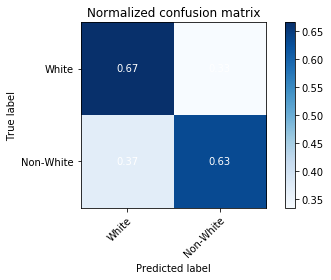

In [60]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['White', 'Non-White']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

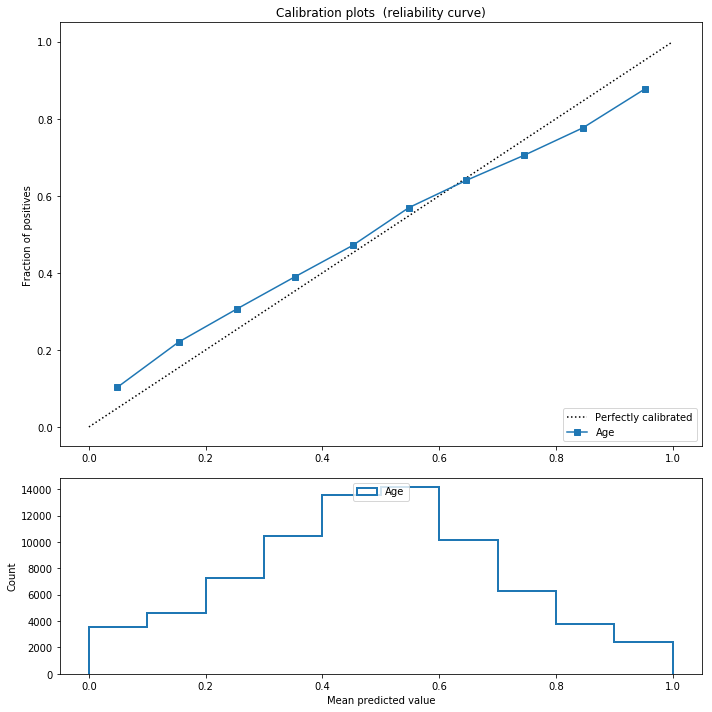

In [62]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Age')

In [63]:
del train, train_ids, train_pred_probs, train_target, train_vec

In [64]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(80226, 16)

In [65]:
descr_df.head()

,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
speech_id,,,,,,,,,,,,,,,,
1060162543,20000627,494,81,106121640.0,D,106,H,IN,W,51.0,1.0,0.0,0.0,Mr. VISCLOSKY,"VISCLOSKY, PETER",exact
980236360,19840726,6999,1127,98113900.0,D,98,H,LA,W,41.0,1.0,0.0,0.0,Mr. TAUZIN,"TAUZIN, WILLIAM",exact
990257551,19860927,597,110,99115351.0,D,99,S,DE,W,44.0,1.0,0.0,0.0,Mr. BIDEN,"BIDEN, JOSEPH",exact
1010233637,19901018,3754,670,101116790.0,R,101,H,CA,W,38.0,1.0,0.0,0.0,Mr. DREIER of Californil,"DREIER, DAVID",exact
980084907,19830801,6277,1012,98111560.0,D,98,H,MA,W,47.0,1.0,0.0,0.0,Mr. STUDDS,"STUDDS, GERRY",exact


In [66]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.092015       0.096453  55.847655  0.523209   0.632962    380.291851


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.72,0.74,1.08,1.03,0.47,1.12
0.6,1.12,1.15,0.99,1.03,1.15,0.94
1.0,1.16,1.11,0.93,0.93,1.39,0.95


In [67]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
numerous merit 	 28342.3
family peers 	 26138.4
badges but 	 26138.4
earned numerous 	 22728.0
scouting he 	 22127.6
only earned 	 21322.7
with scouting 	 21191.9
troop participating 	 20345.8
many scout 	 19518.7
scout activities 	 19132.0


bin,1,2,3,4
badges but,0.0,0.0,34.0,44.0
earned numerous,1.0,2.0,34.0,43.0
family peers,0.0,0.0,34.0,44.0
many scout,0.0,0.0,44.0,43.0
numerous merit,0.0,0.0,31.0,44.0
only earned,0.0,0.0,37.0,42.0
scout activities,0.0,0.0,45.0,43.0
scouting he,0.0,0.0,41.0,44.0
troop participating,0.0,0.0,45.0,44.0
with scouting,1.0,1.0,41.0,44.0


In [68]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 1.00):

date                       20080618
char_count                     4560
word_count                      812
speakerid               1.10119e+08
Party                             R
Congress                        110
Chamber                           H
State                            AZ
Ethnicity                         W
Age                              51
Age_lt_med                        1
NonWhite                          0
Female                            0
speaker       Mr. FRANKS of Arizona
Full Name             FRANKS, TRENT
match                         exact
Name: 1100175910, dtype: object

 Madam Speaker. I stand once again before this House with yet another Sunset Memorial. It is June 18. 2008 in the land of the free and the home of the brave. and before the sun sets today in America. almost 4.000 more defenseless unborn children were killed by abortion on demand. Thats just today. Madam Speaker. Thats more than the number of innocen